In [1]:
name = '2016-10-28-xarray-intro'
title = 'Introduction to xarray'
tags = 'netcdf, io, xarray'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML, Image

html = connect_notebook_to_post(name, title, tags, author)

`xarray` Python library is great for analysing multi-dimensional arrays of data with labelled dimensions, which is a common situation in geosciences.

According to the docs, xarray has two core data structures. Both are fundamentally N-dimensional:

* `DataArray` is our implementation of a labeled, N-dimensional array. It is an N-D generalization of a `pandas.Series`.
* `Dataset` is a multi-dimensional, in-memory array database. It serves a similar purpose in xarray to the `pandas.DataFrame`.

Essentially, xarray adds dimensions names and coordinate indexes to `numpy.ndarray`. This significantly simplifies such operations like indexing, subsetting, broadcasting and even plotting.

Let's have a look.

First, we import some necessary modules, including of course `xarray`:

In [3]:
import numpy as np
import xarray as xr

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

The following examples will be done for ERA-Interim reanalysis data of 2-m temperature and mean sea level pressure. As we will see, these are global daily data for 2014-2015. 

In [6]:
ds = xr.open_dataset('../data/tsurf_slp.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 730)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 2014-01-01 2014-01-02 2014-01-03 ...
Data variables:
    msl        (time, latitude, longitude) float64 1.026e+05 1.026e+05 ...
    t2m        (time, latitude, longitude) float64 254.0 254.0 254.0 254.0 ...
Attributes:
    Conventions: CF-1.6
    history: 2016-10-27 15:50:23 GMT by grib_to_netcdf-1.16.0: grib_to_netcdf /data/data01/scratch/_mars-atls17-95e2cf679cd58ee9b4db4dd119a05a8d-2Gya_b.grib -o /data/data01/scratch/_grib2netcdf-atls18-95e2cf679cd58ee9b4db4dd119a05a8d-DjolHO.nc -utime

Among other things, xarray prints out metadata in a much more readable format than, say, netCDF4.

### Extracting variables

Since a `Dataset` is a `dict`-like object, variables can be accessed by keys.

In [7]:
ds['t2m']

<xarray.DataArray 't2m' (time: 730, latitude: 241, longitude: 480)>
[84446400 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 2014-01-01 2014-01-02 2014-01-03 ...
Attributes:
    units: K
    long_name: 2 metre temperature

But often it's even more convenient to access them as attributes of a `Dataset`.

In [8]:
t2m = ds.t2m

### Key properties of a DataArray

In [9]:
t2m.shape

(730, 241, 480)

In [10]:
t2m.ndim

3

etc...

### Indexing

#### 1. positional and by integer label, like numpy

```python
t2m[456, :, 123]
```

#### 2. positional and by coordinate label, like pandas

```python
t2m.loc[dict(longitude=2.25)]
```

#### 3. by dimension name and integer label

```python
t2m[:2, :, 0]
```

```python
t2m.isel(longitude=0, time=slice(None, 2))
```

#### 4. by dimension name and coordinate label

In [11]:
import datetime

In [12]:
time_start = datetime.datetime.strptime('2014-02-03', '%Y-%m-%d')
time_end = datetime.datetime.strptime('2014-02-05', '%Y-%m-%d')
print('{}\n{}'.format(time_start, time_end))

2014-02-03 00:00:00
2014-02-05 00:00:00


```python
t2m.sel(time=slice(time_start, time_end))
```

### Nearest neighbour lookups

The following line would not work, because neither longitude coordinate array contains a value of `10`, nor latitude contains `20`.

```python
t2m.sel(longitude=10, latitude=20)  # Results in KeyError
```

However, we can use a built-in nearest-neighbour lookup method to find an element closest to the given coordinate values.

```python
t2m.sel(longitude=10, latitude=15,  method='nearest')
```

### Saving data to netCDF

Let's extract a subset of the original data:

In [13]:
new_data = t2m.sel(longitude=slice(-5, 10), latitude=slice(55, 44))

In [14]:
new_data.shape

(730, 15, 14)

Saving data to a netCDF file cannot get any easier:

new_data.to_dataset('test.nc')

### Converting to and from other objects

In [15]:
new_data.to_dataframe().head()

t2m
time       latitude longitude            
2014-01-01 54.75    0.00       279.789883
                    0.75       280.128114
                    1.50       280.407692
                    2.25       280.628617
                    3.00       280.481985

In [16]:
new_data.to_series().head()

time        latitude  longitude
2014-01-01  54.75     0.00         279.789883
                      0.75         280.128114
                      1.50         280.407692
                      2.25         280.628617
                      3.00         280.481985
Name: t2m, dtype: float64

#### Convert from `pandas.DataFrame`

In [17]:
import pandas as pd
import string
df = pd.DataFrame(np.random.randn(365, 5),
                  index=pd.date_range(start='2014-1-1', periods=365),
                  columns=list(string.ascii_letters[:5]))

In [18]:
df.head()

,a,b,c,d,e
2014-01-01,1.351879,0.870072,-0.409061,0.235366,0.105600
2014-01-02,0.310733,0.002810,0.478646,-1.081601,0.450579
2014-01-03,-0.597310,0.085438,-0.081509,-1.969619,-1.274106
2014-01-04,-0.385572,2.061413,-0.417466,-0.026453,1.035422
2014-01-05,0.237001,0.025233,0.088798,0.850684,1.481579


In [19]:
df_ds = xr.Dataset.from_dataframe(df)
df_ds

<xarray.Dataset>
Dimensions:  (index: 365)
Coordinates:
  * index    (index) datetime64[ns] 2014-01-01 2014-01-02 2014-01-03 ...
Data variables:
    a        (index) float64 1.352 0.3107 -0.5973 -0.3856 0.237 0.3082 ...
    b        (index) float64 0.8701 0.00281 0.08544 2.061 0.02523 2.181 -1.3 ...
    c        (index) float64 -0.4091 0.4786 -0.08151 -0.4175 0.0888 -0.415 ...
    d        (index) float64 0.2354 -1.082 -1.97 -0.02645 0.8507 0.9201 ...
    e        (index) float64 0.1056 0.4506 -1.274 1.035 1.482 -0.4497 -1.06 ...

### GroupBy operations and resampling

xarray data structures allow us to perform resampling really easily:

In [20]:
ten_daily = t2m.resample('W', dim='time', how='mean')

Being `pandas`'s sibling, xarray supports [groupby](http://xarray.pydata.org/en/stable/groupby.html) methods. For example, in the following line of code we do averaging of temperature by seasons (just 1 line of code!).

In [21]:
seas = t2m.groupby('time.season').mean('time')
print(seas.season)

<xarray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'


Note how the time dimension was transformed into a 'season' dimension with the appropriate labels.

### Plots - plots - plots

In [22]:
import cartopy.crs as ccrs
from calendar import month_name

#### Basics

You can use OO approach:

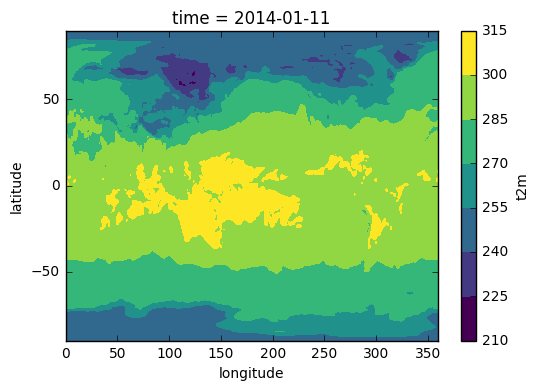

In [23]:
t2m.isel(time=10).plot.contourf()

Or create a figure and axis first, and then pass that as an argument to a plotting fucntions

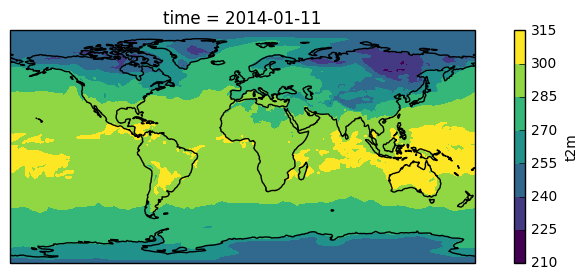

In [24]:
fig, ax = plt.subplots(figsize=(10, 3),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
t2m.isel(time=10).plot.contourf(ax=ax)
ax.coastlines()

#### Now to something more interesting...

First, let's wrap the previous example into a small function:

In [25]:
def plot_field(da, ax=None, title=None):

    if ax is None: 
        fig, ax = plt.subplots(figsize=(10, (da.shape[0] / da.shape[1]) * 10),
                               subplot_kw=dict(projection=ccrs.PlateCarree()))

    da.plot.contourf(ax=ax)
    ax.coastlines()
    if title is not None: 
        ax.set_title(title)

Next, perform a monthly averaging on the original global data:

In [26]:
monthly_t2m = t2m.groupby('time.month').mean('time')

And finally, plot the result.

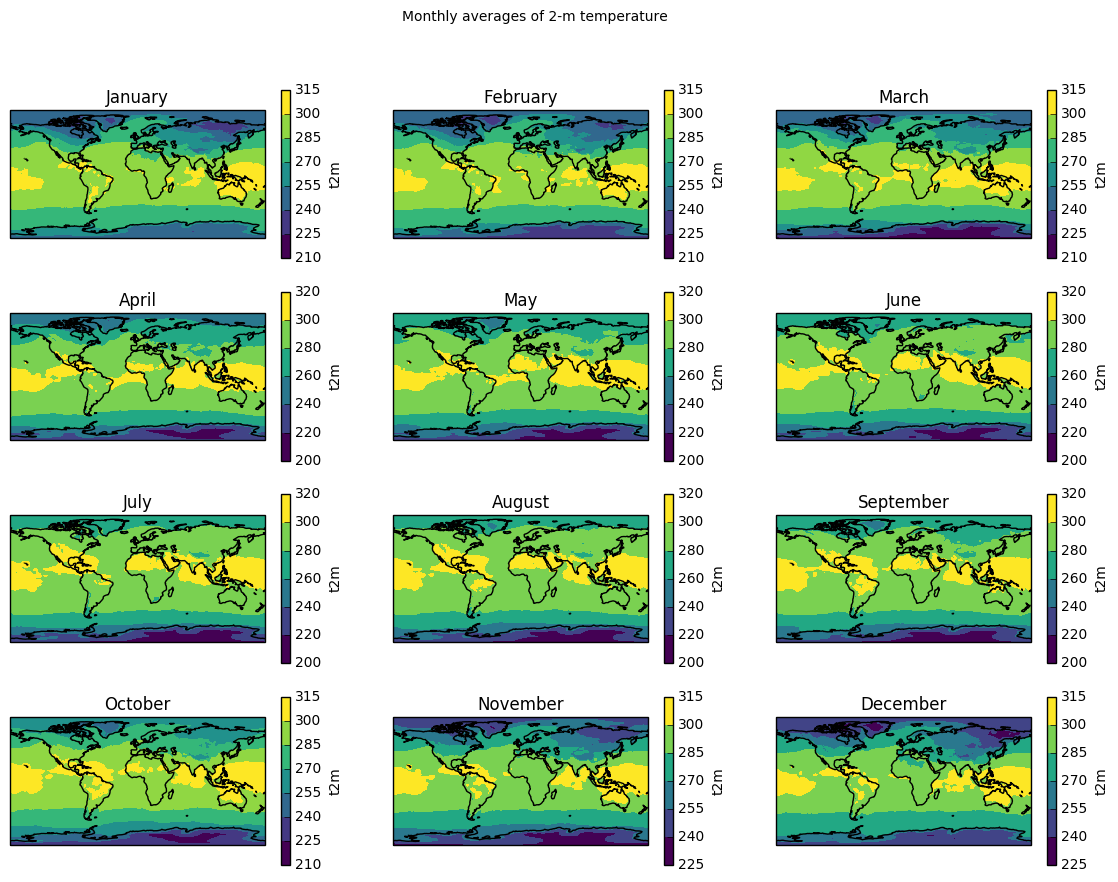

In [27]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(14, 10),
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

fig.suptitle('Monthly averages of 2-m temperature')
axes = axs.flatten()
for month in range(1, 13): 
    ax = axes[month-1]
    plot_field(monthly_t2m.sel(month=month),
               ax=ax, title=month_name[month])

It's always good to close the file you are reading data from.

In [28]:
ds.close()

## References
This notebook was inspired by:
* [xarray documentation and examples](http://xarray.pydata.org/en/stable/examples.html)
* [Nicolas Fauchereau's notebook](https://github.com/nicolasfauchereau/metocean/blob/master/notebooks/xray.ipynb)

In [29]:
HTML(html)